In [1]:
from numpy import ones, zeros, pi, sin, cos, exp, sign, r_, mean, power
import numpy as np
import base64
from compress_functions import *
from TNCaprs import *
from video_encoding import *
from jpeg123 import *
from bitarray import bitarray
import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# You can copy the compiled libpll.c from Part II or recompile pll.c with this command
!cc -fPIC -shared -o libpll.so pll.c

In [ ]:
# create loopback
!sudo modprobe snd_aloop
!aplay -L | grep -i plughw:card=loopback
!aplay -l | grep -i loopback

Password:

In [ ]:
# confirm 13 devices
sd.query_devices()

In [ ]:
# set RPi loopback settings
builtin_idx = 0
usb_idx = 1
loop_idx = 3
loop_idx_rcv = 2
sd.default.samplerate = 48000
sd.default.channels = 1

### Necessary Functions

In [ ]:
# try putting TNC class in here instead

array_1d_int = npct.ndpointer(dtype=np.int32, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]

# function to compute least common multiple
def lcm(numbers):
    return reduce(lambda x, y: (x*y)//gcd(x,y), numbers, 1)

class TNCaprs_ipynb: 
    def __init__(self, fs=48000.0, Abuffer=1024, Nchunks=10):
        
        #  Implementation of an afsk1200 TNC. 
        #
        #  The TNC processes `Abuffer` long buffers until `Nchunks` number of buffers are 
        #  collected into a large one.
        #  This is because python is able to more efficiently process larger buffers than smaller ones.
        #  Then, the resulting large buffer is demodulated, sampled, and packets extracted.
        #
        # Inputs:
        #   fs      - sampling rate
        #   TBW     - TBW of the demodulator filters
        #   Abuffer - Input audio buffers from Pyaudio
        #   Nchunks - Number of audio buffers to collect before processing
        #   apll    - nudge factor of the PLL
        
        ## compute sizes based on inputs
        self.TBW = 2.0   # TBW for the demod filters
        self.N = (int(fs/1200*self.TBW)//2)*2+1   # length of the mark-space filters for demod
        self.fs = fs     # sampling rate   
        self.BW = 1200      # BW of filter based on TBW
        self.Abuffer = Abuffer             # size of audio buffer
        self.Nchunks = Nchunks             # number of audio buffers to collect
        self.Nbuffer = Abuffer*Nchunks+(self.N*3-3)         # length of the large buffer for processing
        self.Ns = 1.0*fs/1200.0 # samples per symbol
        
        ## state variables for the modulator
        self.prev_ph = 0  # previous phase to maintain continuous phase when recalling the function
        
        ## generate filters for the demodulator
        self.h_lp = signal.firwin(self.N,self.BW/fs*1.0,window='hanning')
        self.h_lpp = signal.firwin(self.N,self.BW*2*1.2/fs,window='hanning')
        self.h_space = self.h_lp*exp(1j*2*pi*(2200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_mark = self.h_lp*exp(1j*2*pi*(1200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_bp = signal.firwin(self.N,self.BW/fs*2.2,window='hanning')*exp(1j*2*pi*1700*(r_[0:self.N]-self.N//2)/fs)

        ## PLL state variables  -- so continuity between buffers is preserved
        self.dpll = np.round(2.0**32 / self.Ns).astype(np.int32)    # PLL step
        self.pll = 0                # PLL counter
        self.ppll = -self.dpll       # PLL counter previous value -- to detect overflow
        self.apll = 0.74             # PLL agressivness (small more agressive)
    
        ## state variable to NRZI2NRZ
        self.NRZIprevBit = bool(1)  
        
        ## State variables for findPackets
        self.state = 'search'   # state variable: 'search' or 'pkt'
        self.pktcounter = 0   # counts the length of a packet
        self.packet = bitarray([0,1,1,1,1,1,1,0]) # current packet being collected
        self.bitpointer = 0   # pointer to advance the search beyond what was already 
                              # searched in the previous buffer

        ## state variables for processBuffer
        self.buff = zeros(self.Nbuffer)   # large overlap-save buffer
        self.chunk_count = 0              # chunk counter
        # bits from end of prev buffer to be copied to beginning of new
        self.oldbits = bitarray([0,0,0,0,0,0,0])    
        self.Npackets = 0                 # packet counter
        
    
    def NRZ2NRZI(self,NRZ, prevBit=True):
        NRZI = NRZ.copy() 
        for n in range(0,len(NRZ)):
            if NRZ[n] :
                NRZI[n] = prevBit
            else:
                NRZI[n] = not(prevBit)
            prevBit = NRZI[n]
        return NRZI
    

    def NRZI2NRZ(self, NRZI):  
        NRZ = NRZI.copy() 
        for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == self.NRZIprevBit
            self.NRZIprevBit = NRZI[n]
        return NRZ
    
    
    def KISS2bits(self,KISS):
        # function that takes a KISS frame sent via TCP/IP and converts it to an APRSpacket bit stream.
        bits = bitarray(endian="little")
        bits.frombytes(KISS)
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
        
        bits.frombytes(fcs.digest())
        return bitarray('01111110') + ax25.bit_stuff(bits) + bitarray('01111110') 
     
        
    def bits2KISS(self,bits):
        # function that takes a bitstream of an APRS-packet, removes flags and FCS and unstuffs the bits
        bitsu = ax25.bit_unstuff(bits[8:-8])
        return  bitsu[:-16].tobytes() 
    
    
    def modulate(self, bits):
        # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, 
        # sampled at fs Hz
        #  Inputs:
        #         bits  - bitarray of bits
        #         fs    - sampling rate
        # Outputs:
        #         sig    -  returns afsk1200 modulated signal
        # Your code here:
        fs = self.fs
        fss = lcm((1200,fs))
        deci = fss//fs

        Nb = fss//1200
        nb = len(bits)
        NRZ = ones((nb,Nb))
        for n in range(0,nb):
            if bits[n]:
                NRZ[n,:]=-NRZ[n,:]

        freq = 1700 + 500*NRZ.ravel()
        ph = 2.0*pi*integrate.cumtrapz(freq)/fss
        sig = cos(ph[::deci])
        # End of your code
        return sig 
    
    def modulatePacket(self, callsign, digi, dest, info, preflags=80, postflags=80):
        # given callsign, digipath, dest, info, number of pre-flags and post-flags, the function contructs
        # an appropriate APRS packet, then converts it to NRZI and calls `modulate` 
        # to afsk1200 modulate the packet. 
        packet = ax25.UI(destination=dest,source=callsign, info=info, digipeaters=digi.split(b','),)
        prefix = bitarray(np.tile([0,1,1,1,1,1,1,0],(preflags,)).tolist())
        suffix = bitarray(np.tile([0,1,1,1,1,1,1,0],(postflags,)).tolist())
        sig = self.modulate(self.NRZ2NRZI(prefix + packet.unparse()+suffix))

        return sig
    

    def demod(self, buff):
        # Demodulates a buffer and returns NRZa. Make sure you only return valid samples.
    
        # Your code here:
        fs = self.fs
        TBW = self.TBW
        N = (int(fs/1200*TBW)//2)*2+1
        BW = TBW/(1.0*N/fs)
        h_lp = self.h_lp
        h_lpp = self.h_lpp
        h_space = self.h_space
        h_mark = self.h_mark
        h_bp = self.h_bp

        buff = np.convolve(buff.copy(),h_bp,'valid')
        mark = abs(np.convolve(buff,h_mark,mode='valid'))
        space = abs(np.convolve(buff,h_space,mode='valid'))
        NRZ = mark-space
        NRZa = np.convolve(NRZ,h_lpp,mode='valid')
        return NRZa


    def FastPLL(self,NRZa):
        recbits = np.zeros(len(NRZa)//(self.fs//1200)*2,dtype=np.int32)
        pll = np.zeros(1,dtype = np.int32)
        pll[0] = self.pll
        ppll = np.zeros(1,dtype = np.int32)
        ppll[0] = self.ppll
                
        NRZb = (NRZa > 0).astype(np.int32)
        tot = libcd.pll(NRZb,len(NRZb),recbits,recbits,pll,ppll,self.dpll,self.apll)
        
        self.ppll = ppll.copy()
        self.pll = pll.copy()
        
        return bitarray(recbits[:tot].tolist())
    
    
    def PLL(self, NRZa):
        idx = zeros(len(NRZa)//int(self.Ns)*2)   # allocate space to save indices        
        c = 0
        
        for n in range(1,len(NRZa)):
            if (self.pll < 0) and (self.ppll >0):
                idx[c] = n
                c = c+1
        
            if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
                self.pll = np.int32(self.pll*self.apll)    
        
            self.ppll = self.pll
            self.pll = np.int32(self.pll+ self.dpll)
    
        return idx[:c].astype(np.int32) 
    

    def findPackets(self,bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
        flg = bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = self.bitpointer
        
        # Loop over bits
        while (n < len(bits)-7) :
            # default state is searching for packets
            if self.state is 'search':
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    self.state = 'pkt'
                    self.packet=flg.copy()
                    self.pktcounter = 8
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1             
            # state is to collect packet data. 
            elif self.state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if self.pktcounter > 200:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        self.state = 'search'
                        self.packet.extend(flg)
                        packets.append(self.packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        self.state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if self.pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer        
                        self.packet.append(bits[n])
                        self.pktcounter = self.pktcounter + 1
                        n = n + 1
                    else:  #runaway packet
                        #runaway packet, switch state to searching, and advance pointer
                        self.state = 'search'
                        n = n + 1
        
        self.bitpointer = n-(len(bits)-7) 
        return packets

        # function to generate a checksum for validating packets
    def genfcs(self,bits):
        # Generates a checksum from packet bits
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
    
        digest = bitarray(endian="little")
        digest.frombytes(fcs.digest())

        return digest


    # function to parse packet bits to information
    def decodeAX25(self,bits, deepsearch=False):
        ax = ax25.AX25()
        ax.info = "bad packet"
        ax.parse(bits)
        return ax
    
    
    def processBuffer(self, buff_in):
        # function processes an audio buffer. It collect several small into a large one
        # Then it demodulates and finds packets.
        #
        # The function uses overlap and save convolution
        # The function returns packets when they become available. Otherwise, returns empty list
        
        N = self.N
        NN = N*3 - 3
        
        Nchunks = self.Nchunks
        Abuffer = self.Abuffer
        fs = self.fs
        Ns = self.Ns
        
        validPackets=[]
        packets=[]
        NRZI=[]
        idx = []
        bits = []
        
        # Fill in buffer at the right place
        self.buff[NN+self.chunk_count*Abuffer:NN+(self.chunk_count+1)*Abuffer] = buff_in.copy()
        self.chunk_count = self.chunk_count + 1  
        
        # number of chunk reached -- process large buffer
        if self.chunk_count == Nchunks:
            # Demodulate to get NRZI
            NRZI = self.demod(self.buff)
            
            # compute sampling points, using PLL
            bits = self.FastPLL(NRZI)
            # In case that buffer is too small, raise an error -- must have at least 7 bits worth
            if len(bits) < 7:
                raise ValueError('number of bits too small for buffer')
            
            # concatenate end of previous buffer to current one
            bits = self.oldbits + self.NRZI2NRZ(bits)
            
            # store end of bit buffer to next buffer
            self.oldbits = bits[-7:].copy()
            # look for packets
            packets = self.findPackets(bits)
            
            # Copy end of sample buffer to the beginning of the next (overlap and save)
            self.buff[:NN] = self.buff[-NN:].copy()
            
            # reset chunk counter
            self.chunk_count = 0
            
            # checksum test for all detected packets
            for n in range(0,len(packets)):
                if len(packets[n]) > 200: 
                    try:
                        ax = self.decodeAX25(packets[n])
                    except:
                        ax = ax25.AX25()
                        ax.info = "bad packet"
                    if ax.info != 'bad packet' and ax.info != 'no decode':
                        validPackets.append(packets[n])                
  
        return validPackets

# Convert from bitarray class to b64 bytes and back
def ee123_bitarr_to_base64(bits: bitarray):
    bN = np.uint32(len(bits)).tobytes()
    mybytes = bN + bits.tobytes()
    return base64.b64encode(mybytes)

def ee123_base64_to_bitarr(b64: str):
    mybytes = base64.b64decode(b64)  # Be careful not to overwrite the builtin bytes class!
    N = np.frombuffer(mybytes[:4], dtype='<u4')[0]
    ba = bitarray()
    ba.frombytes(mybytes[4:])
    return ba[:N]

def file_to_b64(fname):
    with open(fname, 'rb') as f:
        raw = f.read()
    # Prepend the number of bytes before encoding
    b64 = base64.b64encode(np.uint32(len(raw)).tobytes() + raw)
    return b64

def enqueue_data(callsign, modem, data, address=None, uid=None, fname="myfile.bin", 
                 comment="UCB EE123 message format", dest=b"APCAL", bsize=240):
    """
    Inputs:
      callsign: your callsign
      modem: a modem object
      data: data to send as a bytes object
      address: address callsign for the message, defaults to your callsign
      uid: optionally specify a UID, otherwise one will be randomly chosen
      fname: filename to send in start packet
      comment: comment for start packet
      dest: should be APCAL for EE123 data
      bsize: number of bytes to send per packet
      
    Outputs:
      Qout: a queue containing modulated packets to transmit
      uid: the uid used for this data transfer
    """
    if address is None:
        address = callsign
    if uid is None:
        uid = np.random.randint(0, 10000)
    uid = bytes("{:04d}".format(uid), 'utf-8')
    addrLen = 8
    if len(address) < addrLen:
        pad = addrLen - len(address)
        address = address + " "*pad
    print("Putting packets in Queue for transmission ID=%s" % uid.decode())
    
    Qout = Queue.Queue()
    
    
    digi = b'WIDE1-1,WIDE2-1'

    # Enqueue START packet
    # formt->  :TGTCALL :START####,filename,comment here
    prefix = bytes(":" + address + " :START", 'utf-8') 
    suffix = bytes("," + fname + "," + comment, 'utf-8')
    info = prefix + uid + suffix
    start_packet = modem.modulatePacket(callsign=callsign, digi=digi, dest=dest, info=info)
    Qout.put(start_packet)
    
    # Enqueue data packets
    # format->   :TGTCALL :<data data data>####
    num_packets = len(data) // bsize
    excess_data = len(data) % bsize
    for i in range(num_packets):
        pcktData = data[i*bsize : (i+1)*bsize]
        prefix = bytes(":" + address + " :", 'utf-8')
        packetNum = bytes("{:04d}".format(i), 'utf-8')
        info = prefix + pcktData + packetNum
        body_packet = modem.modulatePacket(callsign=callsign, digi=digi, dest=dest, info=info)
        Qout.put(body_packet)
    
    
    #left over packet
    if excess_data > 0:
        excess_pcktData = data[num_packets*bsize :]
        prefix = bytes(":" + address + " :", 'utf-8')
        packetNum = bytes("{:04d}".format(num_packets), 'utf-8')
        info = prefix + excess_pcktData + packetNum
        body_packet = modem.modulatePacket(callsign=callsign, digi=digi, dest=dest, info=info)
        Qout.put(body_packet)
        
    # Enqueue END packet   
    # format->    :YOURCALL :END####
    info = bytes(":" + address + " :END", 'utf-8') + uid
    end_packet = modem.modulatePacket(callsign=callsign, digi=digi, dest=dest, info=info)
    Qout.put(end_packet)
    
    return Qout, uid

# Define the callback factory so we can specify which non-global queue we want
def make_QR_callback(Qin):
    def queueREPLAY_callback(indata, outdata, frames, time, status):
#         assert frames == 1024
        if status:
            print(status)
        outdata[:] = indata
        Qin.put(indata.copy()[:, 0]) # Global queue
    return queueREPLAY_callback

print("all good!")

### Image Testing

In [ ]:
# test image
test_png = "creek.png"
test_jpeg = "creek.jpeg123"
test_output = "creek_reconstructed.png"
packet_output = "server_creek.jpeg123"

# test sending a single image
img = Image.open(test_png)
np_img = np.array(img)[:,:,0:3]
jpeg123_encoder(np_img, test_jpeg, quality=50)

base64_img = file_to_b64(test_jpeg)
print(len(base64_img))


In [ ]:
%matplotlib inline
fname = test_png
a = Image.open(fname)
plt.imshow(a);

In [11]:
callsign = "EE1233-8"
fs = 48000
modem = TNCaprs_ipynb(fs=fs, Abuffer=1024, Nchunks=10)
fname = "creek_stream.jpeg123"

print("Putting packets in Queue")

# Enqueue the file
file_b64 = file_to_b64("creek.jpeg123")
Qout, uid = enqueue_data(callsign=callsign, modem=modem, data=file_b64, uid=1010, fname=fname)

print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")

Putting packets in Queue
Putting packets in Queue for transmission ID=1010
Done. UID=1010
There are 58 packets in Qout


In [10]:
Qin = Queue.Queue()
# This stream captures samples on loopback_rcv and plays them on the built in device.
# Remember that loopback is connected to loopback_rcv.
st_replay = sd.Stream(device=(loop_idx_rcv, builtin_idx), blocksize=modem.Abuffer, callback=make_QR_callback(Qin))
print("Starting stream")
st_replay.start()
starttime = time.time()

# Your code here:
while not Qout.empty():
    sd.play(Qout.get()*0.15, samplerate=48000, device=loop_idx, blocking=True)
    time.sleep(0.1)
# End of your code

# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

print(f"Done: {time.time() - starttime:.2f} s")
print(f"There are {Qin.qsize()} buffers in Qin")

Starting stream


KeyboardInterrupt: 

In [27]:
# Decode the recording
print("decoding packets")
starttime = time.time()

rec_fname = "creek_stream.jpeg123"  # Overwrite this variable with the specified name
# Your code here:
pcktCount = 0
unorderedData = []
idxs = []
uid = 0
while not Qin.empty():
    # Partition input into individual packets
    pckts = modem.processBuffer(Qin.get())
    pcktCount += len(pckts)
    for p in pckts:
        # Decode packet
        decodedPckt = modem.decodeAX25(p)
        # Decode relevant packet information into dictionary
        info = decodedPckt.info.strip()
        pDict = decode_ee123_message(info)
        if pDict['isstart']:
            print("Start Packet Found")
            print("UID:", pDict['uid'])
            uid = pDict['uid']
        elif pDict['isend']:
            print("End Packet Found")
            print("UID:", pDict['uid'])
        else:
            # Track sequence idx of data segment in adjacency list
            # along with a list of data segments(2D list)
            idxs.append(pDict['seq'])
            unorderedData.append([base64.b64decode(pDict['data'])])
print("Processing Complete. Packets Found:", pcktCount)

decoding packets
packet found!
Start Packet Found
UID: 1010
packet found!
['0000']
packet found!
['0000', '0001']
packet found!
['0000', '0001', '0002']
packet found!
['0000', '0001', '0002', '0003']
packet found!
['0000', '0001', '0002', '0003', '0004']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012']
packet found!
['0

packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '00

packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0

packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077']
packet found!
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0

In [29]:
idxs = np.array(idxs).astype(int)
# Reconstruct Data in proper order
orderedData = bytearray(unorderedData[np.where(idxs == 0)[0][0]][0])
for i in range(1, len(idxs)):
    # Using the adjacency list, order data in increasing order
    orderedData.extend(unorderedData[np.where(idxs == i)[0][0]][0])
# file_to_b64 prepends the data with the file size
sizeInBytes = orderedData[:4]
binary = orderedData[4:]
# End of your code
# Save the reconstructed file
with open("rec_" + rec_fname, 'wb') as f:
    f.write(binary)

print(f"Done: {time.time() - starttime:.2f} s")

Done: 98.74 s


In [30]:
decoded_img = jpeg123_decoder("rec_creek_stream.jpeg123")
pil_image = Image.fromarray(decoded_img.astype(np.uint8),"RGB")

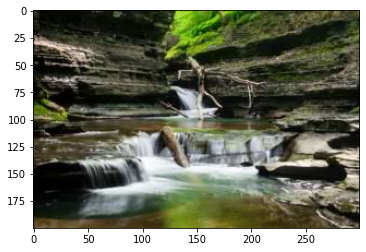

In [31]:
plt.imshow(pil_image)

## Video Loopback

In [12]:
# png settings
cal = "Rolling_cal"
dog = "dog"
andy = "Andy_Video"
creek = "creek"
noodles = "simple_shape"
homer = "simpson"
ice = "ice_growing"
galaxy = "milkyway"
comp = "competition_img"

# pick your video:
file = comp

input_png = file + ".png"
enc_jpeg123 = file +".jpeg123"
output_png = "rec_" + file + ".png"

In [13]:
callsign = "EE1233-8"
fs = 48000
modem = TNCaprs_ipynb(fs=fs, Abuffer=1024, Nchunks=10)

In [14]:
# Load apng into individual png files
im = APNG.open(input_png)
input_files, rgb_array = [], []
for i, (png, control) in enumerate(im.frames):
    frame = "input_frames/{i}.png".format(i=i)
    input_files.append(frame)
    png.save(frame)

In [15]:
# load pngs into a numpy array
for i in range(len(input_files)):
    img = Image.open(input_files[i])
    rgb_array.append(np.array(img)[:,:,0:3])
print(np.shape(rgb_array))

(9, 160, 285, 3)


In [21]:
# call jpeg123_video_encoder (jpeg123.py)
# loop to find max packets
packets, quality = 0, 30
while packets < 58:
    jpeg123_video_encoder(np.array(rgb_array), enc_jpeg123, quality=quality)
    data_base64 = file_to_b64(enc_jpeg123)
    Qout, uid = enqueue_data(callsign=callsign, modem=modem, data=data_base64, uid=1010, fname=output_png)
    packets = Qout.qsize()
    quality += 1
    print(packets)
print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  93 134 153 161 165 166 167]
  [ 93 153 165 167 168 168 168 166]
  [134 165 168 168 168 167 168 168]
  [153 167 168 166 167 168 168 168]
  [161 168 168 167 168 168 168 168]
  [165 168 167 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]]

 [[ 93 153 165 167 168 168 168 166]
  [153 167 168 166 167 168 168 168]
  [165 168 167 168 168 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168 168 168 168]]

 [[134 165 168 168 168 167 168 168]
  [165 168 167 168 168 168 168 168]
  [168 167 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [167 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]]

 [[153 167 168 166 167 168 168 168]
  [167 166 168 168 168 168 168 168]
  [168 168 168 168 168 168 168 168]
  [166 168 168 168 168

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  90 130 148 156 159 161 162]
  [ 90 148 159 162 162 162 162 161]
  [130 159 162 162 162 162 162 162]
  [148 162 162 161 162 162 162 162]
  [156 162 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]]

 [[ 90 148 159 162 162 162 162 161]
  [148 162 162 161 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162 162 162 162]]

 [[130 159 162 162 162 162 162 162]
  [159 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]]

 [[148 162 162 161 162 162 162 162]
  [162 161 162 162 162 162 162 162]
  [162 162 162 162 162 162 162 162]
  [161 162 162 162 162

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  87 126 143 151 154 156 157]
  [ 87 143 154 157 157 157 157 156]
  [126 154 157 157 157 157 157 157]
  [143 157 157 156 157 157 157 157]
  [151 157 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]]

 [[ 87 143 154 157 157 157 157 156]
  [143 157 157 156 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157 157 157 157]]

 [[126 154 157 157 157 157 157 157]
  [154 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]]

 [[143 157 157 156 157 157 157 157]
  [157 156 157 157 157 157 157 157]
  [157 157 157 157 157 157 157 157]
  [156 157 157 157 157

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

[[[  1  84 122 139 146 150 151 152]
  [ 84 139 150 152 152 153 153 151]
  [122 150 152 153 153 152 152 152]
  [139 152 153 151 152 152 152 153]
  [146 152 153 152 152 153 153 153]
  [150 153 152 152 153 153 153 153]
  [151 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]]

 [[ 84 139 150 152 152 153 153 151]
  [139 152 153 151 152 152 152 153]
  [150 153 152 152 153 153 153 153]
  [152 151 152 153 153 153 153 153]
  [152 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153 153 153 153]]

 [[122 150 152 153 153 152 152 152]
  [150 153 152 152 153 153 153 153]
  [152 152 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [153 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]
  [152 153 153 153 153 153 153 153]]

 [[139 152 153 151 152 152 152 153]
  [152 151 152 153 153 153 153 153]
  [153 152 153 153 153 153 153 153]
  [151 153 153 153 153

KeyboardInterrupt: 

In [23]:
# data to transmit
#data_base64 = file_to_b64(enc_jpeg123)
#print(len(data_base64))

6552


In [24]:
#Qout, uid = enqueue_data(callsign=callsign, modem=modem, data=data_base64, uid=1010, fname=fname)

#print("Done. UID=%s" % uid.decode())
#print(f"There are {Qout.qsize()} packets in Qout")

Putting packets in Queue for transmission ID=1010
Done. UID=1010
There are 30 packets in Qout


In [25]:
Qin = Queue.Queue()
# This stream captures samples on loopback_rcv and plays them on the built in device.
# Remember that loopback is connected to loopback_rcv.
st_replay = sd.Stream(device=(loop_idx_rcv, builtin_idx), blocksize=modem.Abuffer, callback=make_QR_callback(Qin))
print("Starting stream")
st_replay.start()
starttime = time.time()

# Your code here:
while not Qout.empty():
    sd.play(Qout.get()*0.15, samplerate=48000, device=loop_idx, blocking=True)
    time.sleep(0.1)
# End of your code

# Remember, we have to stop and close the stream.
st_replay.stop()
st_replay.close()

print(f"Done: {time.time() - starttime:.2f} s")
print(f"There are {Qin.qsize()} buffers in Qin")

Starting stream
Done: 139.30 s
There are 6529 buffers in Qin


In [26]:
# Decode the recording
print("decoding packets")
starttime = time.time()

rec_fname = enc_jpeg123  # Overwrite this variable with the specified name
# Your code here:
pcktCount = 0
unorderedData = []
idxs = []
uid = 0
while not Qin.empty():
    # Partition input into individual packets
    pckts = modem.processBuffer(Qin.get())
    pcktCount += len(pckts)
    for p in pckts:
        # Decode packet
        decodedPckt = modem.decodeAX25(p)
        # Decode relevant packet information into dictionary
        info = decodedPckt.info.strip()
        pDict = decode_ee123_message(info)
        if pDict['isstart']:
            print("Start Packet Found")
            print("UID:", pDict['uid'])
            uid = pDict['uid']
        elif pDict['isend']:
            print("End Packet Found")
            print("UID:", pDict['uid'])
        else:
            # Track sequence idx of data segment in adjacency list
            # along with a list of data segments(2D list)
            idxs.append(pDict['seq'])
            unorderedData.append([base64.b64decode(pDict['data'])])
print("Processing Complete. Packets Found:", pcktCount)

decoding packets
split: ['creek_stream.jpeg123', 'UCB EE123 message format']
Start Packet Found
UID: 1010
End Packet Found
UID: 1010
Processing Complete. Packets Found: 46


In [27]:
idxs = np.array(idxs).astype(int)
# Reconstruct Data in proper order
orderedData = bytearray(unorderedData[np.where(idxs == 0)[0][0]][0])
for i in range(1, len(idxs)):
    # Using the adjacency list, order data in increasing order
    orderedData.extend(unorderedData[np.where(idxs == i)[0][0]][0])
# file_to_b64 prepends the data with the file size
sizeInBytes = orderedData[:4]
binary = orderedData
# Save the reconstructed file
with open("rec_" + rec_fname, 'wb') as f:
    f.write(binary)

print(f"Done: {time.time() - starttime:.2f} s")

Done: 25.89 s


In [28]:
print(len(binary))

7744


In [29]:
from reconstruction import *
from jpeg123 import *

In [31]:
jpeg123_video_decoder("rec_" + enc_jpeg123, output_png)

decoding video!
b'<\x1e'
b'\x00\x00'
b'\xff\xd8'
video saved.  reconstructed_cal.png


In [22]:
###################### it works! time to send to the server. #####################

In [20]:
server_callsign = "NU6XB"
jpeg123_video_encoder(np.array(rgb_array), enc_jpeg123, blockDepth=9, quality=12)
data_base64 = file_to_b64(enc_jpeg123)

(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)


(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
input overflow
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
input underflow
input underflow
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9, 8, 8)
(9,

In [21]:
Qout, uid = enqueue_data(callsign=callsign, modem=modem, address=server_callsign, data=data_base64,
                         comment="github:final-project-part4-winningteamnamept4", uid=1100, fname="anotha_" + output_png)

print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")

Putting packets in Queue for transmission ID=1100
Done. UID=1100
There are 46 packets in Qout


In [28]:
Qin = Queue.Queue()
print("Starting transmission")
starttime = time.time()
while not Qout.empty():
    sd.play(Qout.get()*0.15, samplerate=48000, device=loop_idx, blocking=True)
    time.sleep(0.2)

print(f"Done: {time.time() - starttime:.2f} s")

Starting transmission
Done: 183.41 s
